In [13]:
import ROOT
import glob
import uproot
import awkward as ak
import time
import matplotlib.pyplot as plt
import vector
import hist
import numpy as np
import mplhep as hep
from scipy.stats import crystalball
import cppyy
from scipy.optimize import curve_fit


from ROOT import RooFit, RooRealVar, RooDataHist
from ROOT import RooDataSet, RooArgList, RooGaussian, RooFormulaVar, RooCrystalBall, RooAddPdf,RooArgSet



In [14]:

diretorios = [
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/100000/*.root",
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/1010000/*.root",
    "/opendata/eos/opendata/cms/Run2016G/DoubleEG/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/250000/*.root"
]

# Expandir caminhos com glob e carregar arquivos
arquivos = glob.glob(diretorios[0]) + glob.glob(diretorios[1]) + glob.glob(diretorios[2])
#print(arquivos)


file_1 = uproot.open(arquivos[0])
file_2 = uproot.open(arquivos[1])
file_3 = uproot.open(arquivos[2])

tree_1 = file_1['Events;1']
tree_2 = file_2['Events;1']
tree_3 = file_3['Events;1']

In [15]:
nElectron_1 = tree_1["nElectron"].array()
eletron_pt_1 = tree_1["Electron_pt"].array()
eletron_eta_1 = tree_1["Electron_eta"].array()
eletron_phi_1 = tree_1["Electron_phi"].array()
eletron_mass_1 = tree_1["Electron_mass"].array()
eletron_charge_1 = tree_1["Electron_charge"].array()

nElectron_2 = tree_2["nElectron"].array()
eletron_pt_2 = tree_2["Electron_pt"].array()
eletron_eta_2 = tree_2["Electron_eta"].array()
eletron_phi_2 = tree_2["Electron_phi"].array()
eletron_mass_2 = tree_2["Electron_mass"].array()
eletron_charge_2 = tree_2["Electron_charge"].array()

nElectron_3 = tree_3["nElectron"].array()
eletron_pt_3 = tree_3["Electron_pt"].array()
eletron_eta_3 = tree_3["Electron_eta"].array()
eletron_phi_3 = tree_3["Electron_phi"].array()
eletron_mass_3 = tree_3["Electron_mass"].array()
eletron_charge_3 = tree_3["Electron_charge"].array()

# Combinar os arrays
Neletron = np.concatenate([nElectron_1, nElectron_2, nElectron_3])
eletron_pt = np.concatenate([eletron_pt_1, eletron_pt_2, eletron_pt_3])
eletron_eta = np.concatenate([eletron_eta_1, eletron_eta_2, eletron_eta_3])
eletron_phi = np.concatenate([eletron_phi_1, eletron_phi_2, eletron_phi_3])
eletron_mass = np.concatenate([eletron_mass_1, eletron_mass_2, eletron_mass_3])
eletron_charge = np.concatenate([eletron_charge_1, eletron_charge_2, eletron_charge_3])


In [16]:
mask_di_eletron = Neletron == 2

In [17]:
eletron_p4 = vector.zip({'pt': eletron_pt,
                      'eta': eletron_eta,
                      'phi': eletron_phi,
                      'mass': eletron_mass})
two_eletron_p4 = eletron_p4[mask_di_eletron]

first_eletron_p4 = two_eletron_p4[:, 0]
second_eletron_p4 = two_eletron_p4[:, 1]
sum_p4 = first_eletron_p4 + second_eletron_p4

In [18]:
two_eletron_charges = eletron_charge[mask_di_eletron]
opposite_sign_eletron_mask = two_eletron_charges[:, 0] != two_eletron_charges[:, 1]
di_eletron_p4_sem_corte = sum_p4[opposite_sign_eletron_mask]
pt_corte = 20
eta_corte = np.abs(2.4)
pt_mask = di_eletron_p4_sem_corte.pt < 40
eta_mask = (di_eletron_p4_sem_corte.eta > -4.8 ) & (di_eletron_p4_sem_corte.eta < 4.8)

combined_mask = pt_mask 

di_eletron_p4 = di_eletron_p4_sem_corte[combined_mask]


di_eletron_mass = di_eletron_p4.mass

In [19]:
pt_sem_corte = di_eletron_p4_sem_corte.pt
pt_com_corte = di_eletron_p4.pt

eta_sem_corte = di_eletron_p4_sem_corte.eta
eta_com_corte = di_eletron_p4.eta

print(pt_sem_corte)
print(pt_com_corte)

[1.96, 26.6, 26.1, 52, 78.3, 89.1, 43.6, ..., 50.7, 112, 38.7, 6.44, 24.5, 14]
[1.96, 26.6, 26.1, 7.4, 16.9, 7.53, 7.25, ..., 12.4, 29.9, 38.7, 6.44, 24.5, 14]


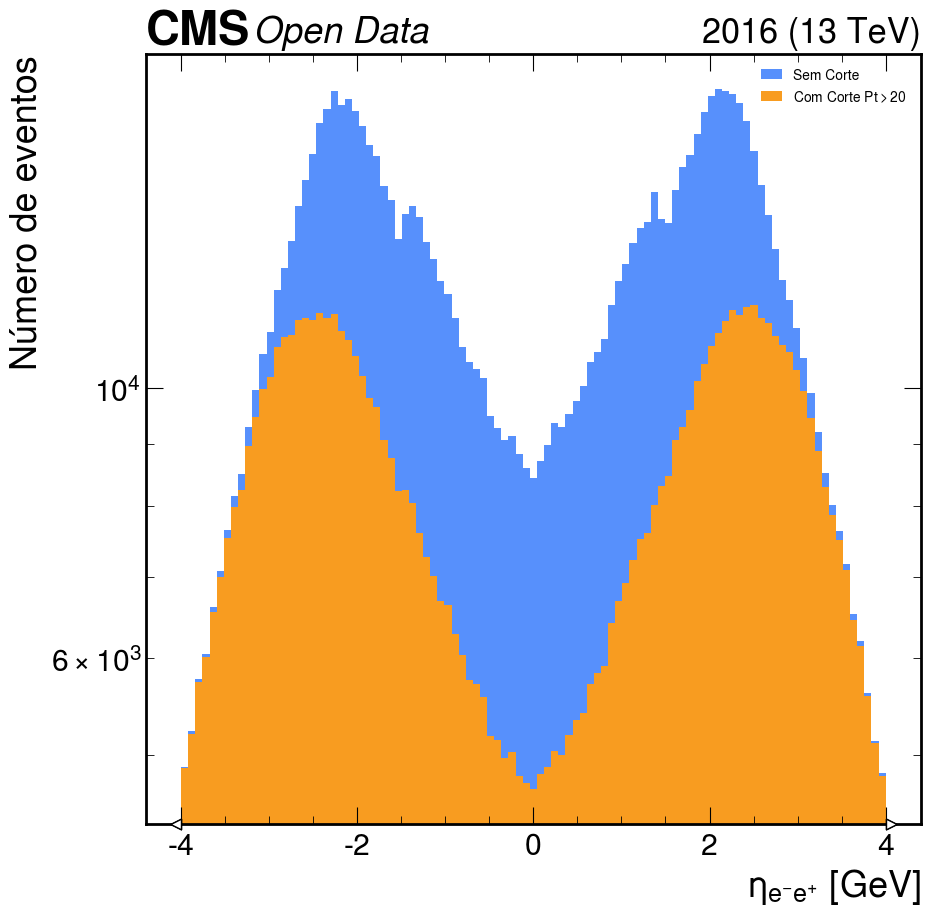

In [29]:

# Gerando os dados (exemplo)
bins = np.linspace(-4, 4, 100)
pt_hist_1 = hist.Hist(hist.axis.Variable(bins, label=r'$\eta_{e^{-}e^{+}}$ [GeV]'))
pt_hist_2 = hist.Hist(hist.axis.Variable(bins, label=r'$\eta_{e^{-}e^{+}}$ [GeV]'))


pt_hist_1.fill(eta_sem_corte)
pt_hist_2.fill(eta_com_corte)

# Usando o estilo CMS
hep.style.use('CMS')

# Plotando os histogramas com rótulos para a legenda
hep.histplot(pt_hist_1, histtype='fill', label='Sem Corte')
hep.histplot(pt_hist_2, histtype='fill', label='Com Corte $Pt > 20 $')


hep.cms.label(data=True, label='Open Data', year=2016)

# Calculando o total de eventos
total_events = int(pt_hist_1.sum() + pt_hist_2.sum())

# Exibindo o texto com o total de eventos
#plt.text(0.95, 0.95, f'Total de eventos: {total_events}\nCortes: $p_T > {pt_corte}$ GeV, $|\\eta| < {eta_corte}$', 
#         ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, 
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# Ajustando rótulos e a escala do gráfico
plt.ylabel('Número de eventos')
plt.yscale('log')  
plt.legend(loc='upper right', fontsize=10, frameon=False)

#plt.savefig('eta.png', dpi=300)

# Exibindo o gráfico
plt.show()
